In [1]:
import grouptesting
from grouptesting.model import *
from grouptesting.algorithms import *
import autograd.numpy as np
from autograd import grad 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import bernoulli
from scipy.optimize import minimize, rosen, rosen_der
from sympy import *

def nCr(n,k):
    return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

np.random.seed(4000)


## Plot ideas:

1. NCOMP vs. NDD for some q, or for three different qs (just to show empirical performance of NDD vs NCOMP) x
2. NCOMP with an achievability bound for some q x
4. NDD with achievability found for some q x

### 2. NCOMP with an achievability bound for some q

l-1, u-1: -0.3228129199218749 5.263980490722658
T:  1
T:  43
T:  84
T:  126
T:  168
T:  209
T:  251
T:  292
T:  334
T:  376
T:  417
T:  459
T:  500
T:  542
T:  584
T:  625
T:  667
T:  709
T:  750
T:  792
T:  834
T:  875
T:  917
T:  958
T:  1000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


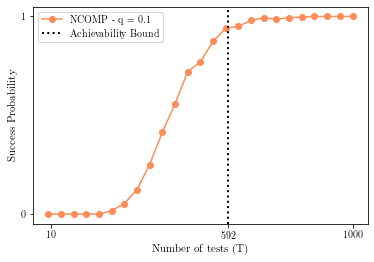

In [11]:
# Define initial parameters
num_tests = 300
n = 1000 # population size
theta = 0.15
C = 2
n_theta = C * (n**theta)
k = round(n_theta) # number of infected
alpha = 0.5
p = alpha/k # Bernoulli test design probability parameter
eta = 0.001
q_results = []

############ RUN EXPERIMENT #####################
for q in [0.10]:
    NCOMP_ber_acc = []
    
    ############## Achievable bound 1 for T ################
    ## Choose delta according to z
    T_array = np.linspace(1, n, 25)
    z = ((1- alpha/(k) * (1-q))**(k-1) + (1/q)*(1 - alpha/(k) * (1-q))**k) / 2
    l = (1 - alpha / k * (1-q))**(k-1)
    u = (1 - alpha / k * (1-q))**(k) * (1/q)
    print("l-1, u-1:", l-1, u-1)
    delta = z - 1
    assert (l-1) < delta < (u-1)
    
    ########### Achievability Bound 2 Method 2 #######
    eta_1, alpha_1, theta_1, q_1 = eta, alpha, theta, q
    n_1 = n
    n_theta_1 = n_theta
    d_1 = round(n_theta_1)
    eps = 1e-12

    # Objective
    Tminus = lambda delta_1: ((1 + eta_1) * theta_1 * (1/(q_1**2)) * (d_1) * (np.log(n_1))) / (alpha_1 * (1 - np.exp(-2)) * (eps + (1+delta_1) - (1- alpha_1/(d_1) * (1-q_1))**(d_1-1))**2)
    Tplus = lambda delta_1: ((1 + eta_1) * (1/(q_1**2)) * (d_1) * (np.log(n_1))) / (alpha_1 * (1 - np.exp(-2)) * (eps + (1+delta_1) - (1/q_1) * (1- alpha_1/(d_1) * (1-q_1))**d_1)**2)
    ff = lambda delta_1: max(Tminus(delta_1), Tplus(delta_1))

    # Constraints
    l = (1 - alpha_1 / d_1 * (1-q_1))**(d_1-1)
    u = (1 - alpha_1 / d_1 * (1-q_1))**(d_1) * (1/q_1)
    bound = (l-1, u-1)

    x0 = delta
    options={'disp': None, 'maxcor': 100, 'ftol': 1e-14, 'gtol': 1e-012, 'eps': 1e-08, 'maxfun': 15000, 'maxiter': 15000, 'iprint': 1, 'maxls': 20}
    gff = grad(ff)
    res = minimize(ff, x0, tol=1e-12, bounds=[bound], jac=gff)
    achiev_bound = res.fun[0]

    ###### Main Experiment loop #####
    
    for T in T_array:
        NCOMP_ber_error = []
        NDD_ber_error = []
        COMP_ber_error = []
        print("T: ", int(round(T)))
        for test in range(num_tests): 
            sigma = D(n, k) # Generate the vector of defectives
            X_ber = Ber(n, int(round(T)), p)
            y_ber = Y(dilution_noise(X_ber, q), sigma)

            # NCOMP - Bernoulli
            sigma_hat_ber = NCOMP(X_ber, y_ber, q=q, delta=delta)
            err = error(sigma, sigma_hat_ber)
            NCOMP_ber_error.append(error(sigma, sigma_hat_ber))

        acc = (num_tests - np.sum(np.array(NCOMP_ber_error))) / num_tests
        NCOMP_ber_acc.append(acc)

            
    ################ Plot ####################
    PAL = ['#fef0d9','#fdcc8a','#fc8d59','#d7301f']
    plt.plot(T_array, NCOMP_ber_acc,'o-', c=PAL[-2], label="NCOMP - q = " + str(round(q, 2)))

#     use LaTeX fonts in the plot
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    matplotlib.rcParams['text.usetex'] = True

    plt.axvline(x=float(achiev_bound), ymin=0, ymax=1, color='black', linestyle='dotted', label="Achievability Bound", linewidth=2)
    plt.xticks(ticks=[10, round((achiev_bound)), round(n)])
    plt.yticks(ticks=[0.0, 1.0])
    plt.xlabel(r'Number of tests (T)', fontsize=11)
    plt.ylabel(r'Success Probability', fontsize=11)
    plt.legend()
    plt.savefig('plots/NCOMP Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.png')
    plt.savefig('plots/NCOMP Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.eps')
    plt.savefig('plots/NCOMP Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.pdf')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


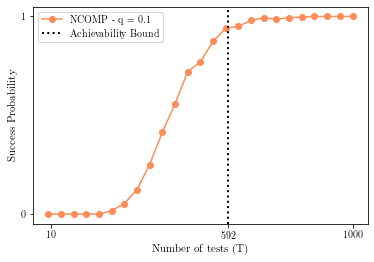

In [12]:
## Redo the plot because the latex font only comes in the second time you save it for some reason.
PAL = ['#fef0d9','#fdcc8a','#fc8d59','#d7301f'] 
plt.plot(T_array, NCOMP_ber_acc,'o-', c=PAL[-2], label="NCOMP - q = " + str(round(q, 2)))

#     use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.usetex'] = True

plt.axvline(x=float(achiev_bound), ymin=0, ymax=1, color='black', linestyle='dotted', label="Achievability Bound", linewidth=2)
plt.xticks(ticks=[10, round(float(achiev_bound)), round(n)])
plt.yticks(ticks=[0.0, 1.0])
plt.xlabel(r'Number of tests (T)', fontsize=11)
plt.ylabel(r'Success Probability', fontsize=11)
plt.legend()
plt.savefig('plots/NCOMP Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.png')
plt.savefig('plots/NCOMP Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.eps')
plt.savefig('plots/NCOMP Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.pdf')
plt.show()

### 3. NDD with Achievability bound for some q

q:  0.1
T:  1
T:  43
T:  84
T:  126
T:  168
T:  209
T:  251
T:  292
T:  334
T:  376
T:  417
T:  459
T:  500
T:  542
T:  584
T:  625
T:  667
T:  709
T:  750
T:  792
T:  834
T:  875
T:  917
T:  958
T:  1000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


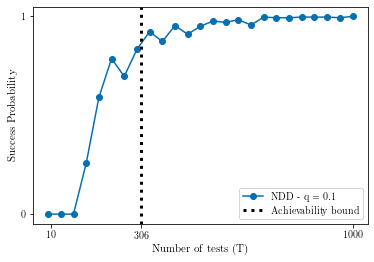

In [13]:
# Define initial para200
n = 1000 # population size
theta = 0.15
C = 2
n_theta = C * (n**theta)
k = round(n_theta) # number of infected
eta = 0.001
q_results = []

np.random.seed(23455324)

############ RUN EXPERIMENT #####################
for q in [0.10]:
    alpha = 0.5
    p = alpha/k # Bernoulli test design probability parameter
    print("q: ", q)
    NDD_ber_acc = []
    NCOMP_ber_acc = []
    
    T_array = np.linspace(1, n, 25)
    pi_init = (q+0.07)
    
    ########### Achievability Bound 2 Method 2 #######
    eta_1, alpha_1, theta_1, q_1 = eta, alpha, theta, q
    n_1 = n
    n_theta_1 = n_theta
    d_1 = round(n_theta_1)
    eps = 1e-12
    
    # Objective
    D_ = lambda _eps: (_eps)*np.log(_eps) - _eps + 1
    T1 = lambda pi: (d_1 * np.log(d_1) * np.exp(alpha_1 * (1-q_1)) / ((alpha_1 * q_1)*D_(pi / (q_1 * np.exp(-alpha_1 * (1-q_1))))))
    T2 = lambda pi: ((1 - (theta_1 - eps)) * d_1 * np.log(n) * np.exp(alpha_1*(1-q_1)) / (alpha_1 * D_(pi * np.exp(alpha_1 * (1-q_1)))))
    T3 = lambda pi: (np.exp(alpha_1) * d_1 * np.log(d_1) / (alpha_1 * (1-q_1)))
    ff = lambda pi: max(T1(pi), T2(pi), T3(pi))
    
    bound = (q, np.exp(-alpha * (1-q))-0.01)

    x0 = pi_init
    gff = grad(ff)
    res = minimize(ff, x0, tol=1e-12, bounds=[bound], jac=gff)
    achiev_bound = res.fun[0]
    pi_NDD = res.x[0]
    assert q <= pi_NDD <= 1

    ###### Main Experiment loop #####
    for T in T_array:
        NDD_ber_error = []
        DD_ber_error = []
        NCOMP_ber_error = []
        print("T: ", int(round(T)))
        for test in range(num_tests): 
            sigma = D(n, k) # Generate the vector of defectives
            X_ber = Ber(n, int(round(T)), p)
            y_ber = Y(dilution_noise(X_ber, q), sigma)
            
            # NDD - Bernoulli
            sigma_hat_ber = NDD(X_ber, y_ber, pi=(pi_NDD), alpha=alpha, T = T, d = k)
            err = error(sigma, sigma_hat_ber)
            NDD_ber_error.append(error(sigma, sigma_hat_ber))

        acc = (num_tests - np.sum(np.array(NDD_ber_error))) / num_tests
        NDD_ber_acc.append(acc)
            
    ################ Plot ####################
    PAL = ['#f1eef6','#bdc9e1','#74a9cf','#0570b0']
    plt.plot(T_array, NDD_ber_acc,'o-', c=PAL[-1], label="NDD - q = " + str(round(q, 2)))

    # use LaTeX fonts in the plot
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    matplotlib.rcParams['text.usetex'] = True

    plt.axvline(x=ff(pi_NDD), ymin=0, ymax=1, color='black', linestyle='dotted', label="Achievability bound", linewidth=3)
    plt.xticks(ticks=[round(10.0), round(ff(pi_NDD)), round(n)])
    plt.yticks(ticks=[0.0, 1.0])
    plt.xlabel(r'Number of tests (T)', fontsize=11)
    plt.ylabel(r'Success Probability', fontsize=11)
    plt.legend()
    plt.savefig('plots/NDD Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', pi = ' + str(round(pi_NDD, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.png')
    plt.savefig('plots/NDD Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', pi = ' + str(round(pi_NDD, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.eps')
    plt.savefig('plots/NDD Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', pi = ' + str(round(pi_NDD, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.pdf')
    plt.show()

### 1. NDD vs NCOMP for some/different qs

In [ ]:
# Define initial parameters
num_tests = 300                                                                                                                                                                                                 
n = 1000 # population size
theta = 0.15
C = 2
n_theta = C * (n**theta)
k = round(n_theta) # number of infected
eta = 0.001
q_results = []

############ RUN EXPERIMENT #####################
for q in [0.000001, 0.15, 0.35, 0.50]:
    alpha = 0.5
    p = alpha/k # Bernoulli test design probability parameter
    print("q: ", q)
    NDD_ber_acc = []
    DD_ber_acc = []
    NCOMP_ber_acc = []
    
    T_array = np.linspace(1, n, 25)
    pi_init = (q+0.07)
    
    ########### Achievability Bound 2 Method 2 #######
    eta_1, alpha_1, theta_1, q_1 = eta, alpha, theta, q
    n_1 = n
    n_theta_1 = n_theta
    d_1 = round(n_theta_1)
    eps = 1e-12
    
    # Objective
    D_ = lambda _eps: (_eps)*np.log(_eps) - _eps + 1
    T1 = lambda pi: (d_1 * np.log(d_1) * np.exp(alpha_1 * (1-q_1)) / ((alpha_1 * q_1)*D_(pi / (q_1 * np.exp(-alpha_1 * (1-q_1))))))
    T2 = lambda pi: ((1 - (theta_1 - eps)) * d_1 * np.log(n) * np.exp(alpha_1*(1-q_1)) / (alpha_1 * D_(pi * np.exp(alpha_1 * (1-q_1)))))
    T3 = lambda pi: (np.exp(alpha_1) * d_1 * np.log(d_1) / (alpha_1 * (1-q_1)))
    ff = lambda pi: max(T1(pi), T2(pi), T3(pi))
    
    bound = (q, np.exp(-alpha * (1-q))-0.01)
    x0 = pi_init
    gff = grad(ff)
    res = minimize(ff, x0, tol=1e-6, bounds=[bound], jac=gff)
    achiev_bound = res.fun[0]
    pi_NDD = res.x[0]
    assert q <= pi_NDD <= 1

    ###### Main Experiment loop #####
    for T in T_array:
        NDD_ber_error = []
        DD_ber_error = []
        NCOMP_ber_error = []
        print("T: ", int(round(T)))
        for test in range(num_tests): 
            sigma = D(n, k) # Generate the vector of defectives
            X_ber = Ber(n, int(round(T)), p)
            y_ber = Y(dilution_noise(X_ber, q), sigma)
            
            # NCOMP - Bernoulli
            # Choose delta according to z
            z = ((1- alpha/(k) * (1-q))**(k-1) + (1/q)*(1 - alpha/(k) * (1-q))**k) / 2
            l = (1 - alpha / k * (1-q))**(k-1)
            u = (1 - alpha / k * (1-q))**(k) * (1/q)
            delta_NCOMP = z - 1
            assert (l-1) < delta_NCOMP < (u-1) 
            sigma_hat_ber = NCOMP(X_ber, y_ber, q=q, delta=delta_NCOMP)
            err = error(sigma, sigma_hat_ber)
            NCOMP_ber_error.append(error(sigma, sigma_hat_ber))
            
            # NDD - Bernoulli
            sigma_hat_ber = NDD(X_ber, y_ber, pi=(pi_NDD), alpha=alpha, T = T, d = k)
            err = error(sigma, sigma_hat_ber)
            NDD_ber_error.append(error(sigma, sigma_hat_ber))

        acc = (num_tests - np.sum(np.array(NDD_ber_error))) / num_tests
        NDD_ber_acc.append(acc)
        acc = (num_tests - np.sum(np.array(NCOMP_ber_error))) / num_tests
        NCOMP_ber_acc.append(acc)
        
    q_results.append([q, T_array, NCOMP_ber_acc, NDD_ber_acc])

0
1
2
3


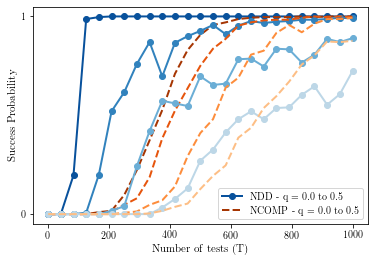

In [9]:
PAL1 = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
PAL2 = ['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
for i in range(len(q_results)):
    print(i)
    q, T_array, NCOMP_ber_acc, NDD_ber_acc = q_results[i]
    
    if (i==0):
        plt.plot(T_array, NDD_ber_acc,'o-', c=PAL1[-1-i], label="NDD - q = 0.0 to 0.5", linewidth=2)
        plt.plot(T_array, NCOMP_ber_acc,'--', c=PAL2[-1-i], label="NCOMP - q = 0.0 to 0.5", linewidth=2)
    else:
        plt.plot(T_array, NDD_ber_acc,'o-', c=PAL1[-1-i], linewidth=2)
        plt.plot(T_array, NCOMP_ber_acc,'--', c=PAL2[-1-i], linewidth=2)
        
    # use LaTeX fonts in the plot
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    matplotlib.rcParams['text.usetex'] = True

    plt.yticks(ticks=[0.0, 1.0])
    plt.xlabel(r'Number of tests (T)', fontsize=11)
    plt.ylabel(r'Success Probability', fontsize=11)

plt.legend()
plt.savefig('plots/NCOMP vs NDD Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.png')
plt.savefig('plots/NCOMP vs NDD Report Nico 2 today' + str(round(C, 2)) + 'qs, q = ' + str(round(q, 2)) + ', delta = ' + str(round(delta, 2)) + ', n = ' + str(n) + ', theta = ' + str(round(theta, 2)) + '.pdf')
plt.show()